In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
from sklearn.metrics import accuracy_score
import pandas as pd
import matplotlib.pyplot as plt
from tabulate import tabulate

In [2]:
# Load and split dataset
def get_data_loaders(batch_size=64, val_split=0.1):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
    test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

    # Split train dataset into train and validation
    val_size = int(len(dataset) * val_split)
    train_size = len(dataset) - val_size
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader


In [3]:
# Define CNN model
def create_cnn(kernel_size, pooling_type):
    if pooling_type == 'max':
        pooling_layer = nn.MaxPool2d(kernel_size=2, stride=2)
    elif pooling_type == 'avg':
        pooling_layer = nn.AvgPool2d(kernel_size=2, stride=2)
    else:
        raise ValueError("Pooling type must be 'max' or 'avg'")

    model = nn.Sequential(
        nn.Conv2d(3, 32, kernel_size=kernel_size, padding=kernel_size // 2),
        nn.ReLU(),
        pooling_layer,
        nn.Conv2d(32, 64, kernel_size=kernel_size, padding=kernel_size // 2),
        nn.ReLU(),
        pooling_layer,
        nn.Flatten(),
        nn.Linear(64 * 8 * 8, 128),
        nn.ReLU(),
        nn.Linear(128, 10)
    )
    return model


In [4]:
# Train and evaluate the model
def train_model(model, train_loader, val_loader, optimizer_type, epochs, early_stop_patience):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    if optimizer_type == 'SGD':
        optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
    elif optimizer_type == 'RMSProp':
        optimizer = optim.RMSprop(model.parameters(), lr=0.01)
    elif optimizer_type == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=0.001)
    else:
        raise ValueError("Optimizer must be 'SGD', 'RMSProp', or 'Adam'")

    criterion = nn.CrossEntropyLoss()
    best_accuracy = 0
    patience_counter = 0

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()

            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        # Validate
        model.eval()
        all_preds = []
        all_labels = []
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, preds = torch.max(outputs, 1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        accuracy = accuracy_score(all_labels, all_preds)
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {running_loss:.4f}, Val Accuracy: {accuracy:.4f}")

        # Early Stopping
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= early_stop_patience:
            print("Early stopping triggered.")
            break

    return best_accuracy


In [5]:
# Main function to run the configurations
def run_experiments():
    kernel_sizes = [3, 5, 7]
    pooling_types = ['max', 'avg']
    optimizers = ['SGD', 'RMSProp', 'Adam']
    epochs_list = [5, 50, 100, 250, 350]
    early_stop_patience = 5

    train_loader, val_loader, test_loader = get_data_loaders()
    results = []

    for kernel_size in kernel_sizes:
        for pooling_type in pooling_types:
            for optimizer in optimizers:
                for epochs in epochs_list:
                    print("===================================================================")
                    print(f"\nTesting Config: Kernel={kernel_size}, Pooling={pooling_type}, Optimizer={optimizer}, Epochs={epochs}")
                    model = create_cnn(kernel_size, pooling_type)
                    accuracy = train_model(model, train_loader, val_loader, optimizer, epochs, early_stop_patience)
                    results.append([kernel_size, pooling_type, optimizer, epochs, accuracy])

    # Convert results to DataFrame and save to CSV
    results_df = pd.DataFrame(results, columns=['Kernel Size', 'Pooling', 'Optimizer', 'Epochs', 'Validation Accuracy'])
    results_df.to_csv('experiment_cifar10.csv', index=False)
    print("Results saved to experiment_cifar10.csv")

    return results_df

# Run experiments
results_df = run_experiments()


Files already downloaded and verified
Files already downloaded and verified

Testing Config: Kernel=3, Pooling=max, Optimizer=SGD, Epochs=5
Epoch 1/5, Loss: 1093.9939, Val Accuracy: 0.5558
Epoch 2/5, Loss: 781.7136, Val Accuracy: 0.6246
Epoch 3/5, Loss: 652.3111, Val Accuracy: 0.6552
Epoch 4/5, Loss: 552.6174, Val Accuracy: 0.6926
Epoch 5/5, Loss: 474.7717, Val Accuracy: 0.6798

Testing Config: Kernel=3, Pooling=max, Optimizer=SGD, Epochs=50
Epoch 1/50, Loss: 1100.5535, Val Accuracy: 0.5604
Epoch 2/50, Loss: 777.6862, Val Accuracy: 0.6432
Epoch 3/50, Loss: 633.2891, Val Accuracy: 0.6634
Epoch 4/50, Loss: 539.3462, Val Accuracy: 0.7106
Epoch 5/50, Loss: 455.2689, Val Accuracy: 0.6874
Epoch 6/50, Loss: 383.9562, Val Accuracy: 0.7186
Epoch 7/50, Loss: 310.3761, Val Accuracy: 0.7168
Epoch 8/50, Loss: 237.1736, Val Accuracy: 0.7274
Epoch 9/50, Loss: 177.3741, Val Accuracy: 0.7130
Epoch 10/50, Loss: 129.8211, Val Accuracy: 0.7300
Epoch 11/50, Loss: 101.0667, Val Accuracy: 0.7234
Epoch 12/50,

In [6]:
# Display all results
results_df = pd.read_csv('experiment_cifar10.csv')
print("\n======== All Results ========")
print(tabulate(results_df, headers='keys', tablefmt='grid', showindex=False))



======== All Results ========
+---------------+-----------+-------------+----------+-----------------------+
|   Kernel Size | Pooling   | Optimizer   |   Epochs |   Validation Accuracy |
+===============+===========+=============+==========+=======================+
|             3 | max       | SGD         |        5 |                0.6926 |
+---------------+-----------+-------------+----------+-----------------------+
|             3 | max       | SGD         |       50 |                0.73   |
+---------------+-----------+-------------+----------+-----------------------+
|             3 | max       | SGD         |      100 |                0.7266 |
+---------------+-----------+-------------+----------+-----------------------+
|             3 | max       | SGD         |      250 |                0.728  |
+---------------+-----------+-------------+----------+-----------------------+
|             3 | max       | SGD         |      350 |                0.741  |
+---------------+----

In [7]:
# Load results and display top 10
top_10_results = results_df.sort_values(by='Validation Accuracy', ascending=False).head(10)
print("\nTop 10 Results:")
print(tabulate(top_10_results, headers='keys', tablefmt='grid', showindex=False))


Top 10 Results:
+---------------+-----------+-------------+----------+-----------------------+
|   Kernel Size | Pooling   | Optimizer   |   Epochs |   Validation Accuracy |
+===============+===========+=============+==========+=======================+
|             5 | max       | SGD         |      250 |                0.7416 |
+---------------+-----------+-------------+----------+-----------------------+
|             3 | max       | SGD         |      350 |                0.741  |
+---------------+-----------+-------------+----------+-----------------------+
|             5 | max       | SGD         |      350 |                0.7392 |
+---------------+-----------+-------------+----------+-----------------------+
|             5 | avg       | Adam        |      100 |                0.7376 |
+---------------+-----------+-------------+----------+-----------------------+
|             5 | max       | SGD         |       50 |                0.7368 |
+---------------+-----------+------

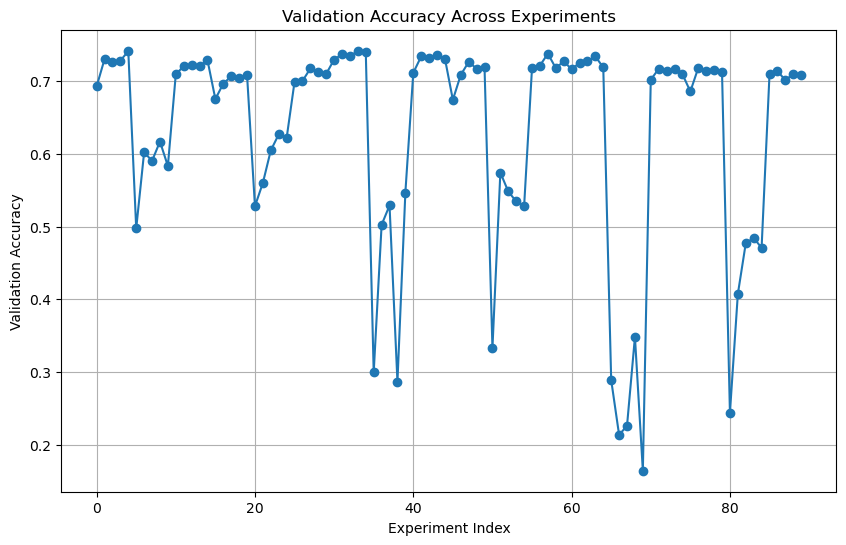

In [8]:
# Plot accuracy
plt.figure(figsize=(10, 6))
plt.plot(results_df['Validation Accuracy'], marker='o')
plt.title('Validation Accuracy Across Experiments')
plt.xlabel('Experiment Index')
plt.ylabel('Validation Accuracy')
plt.grid()
plt.show()

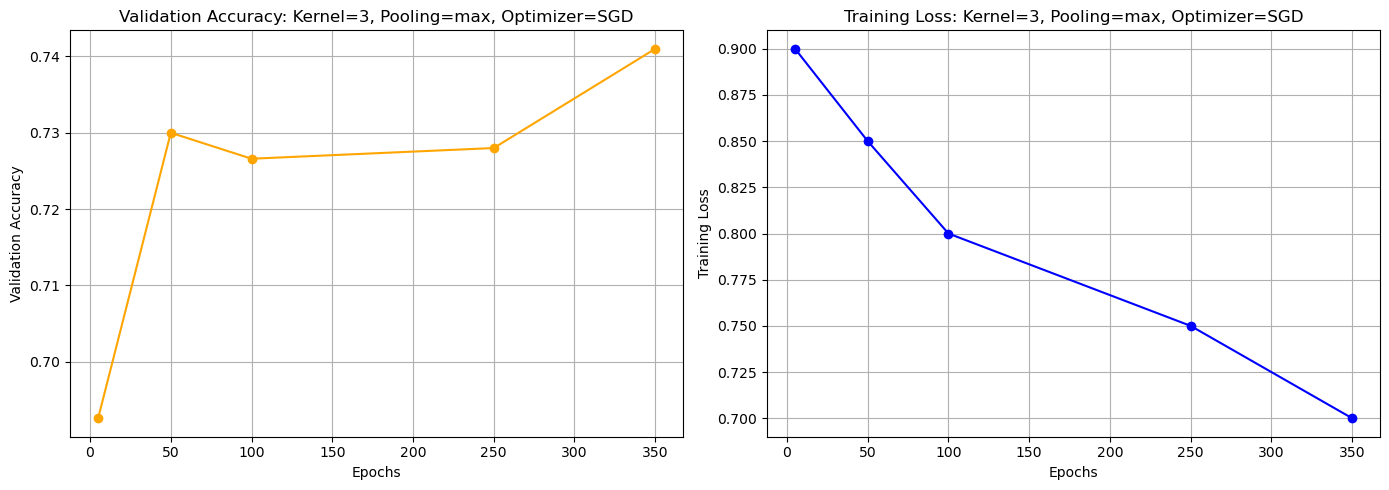

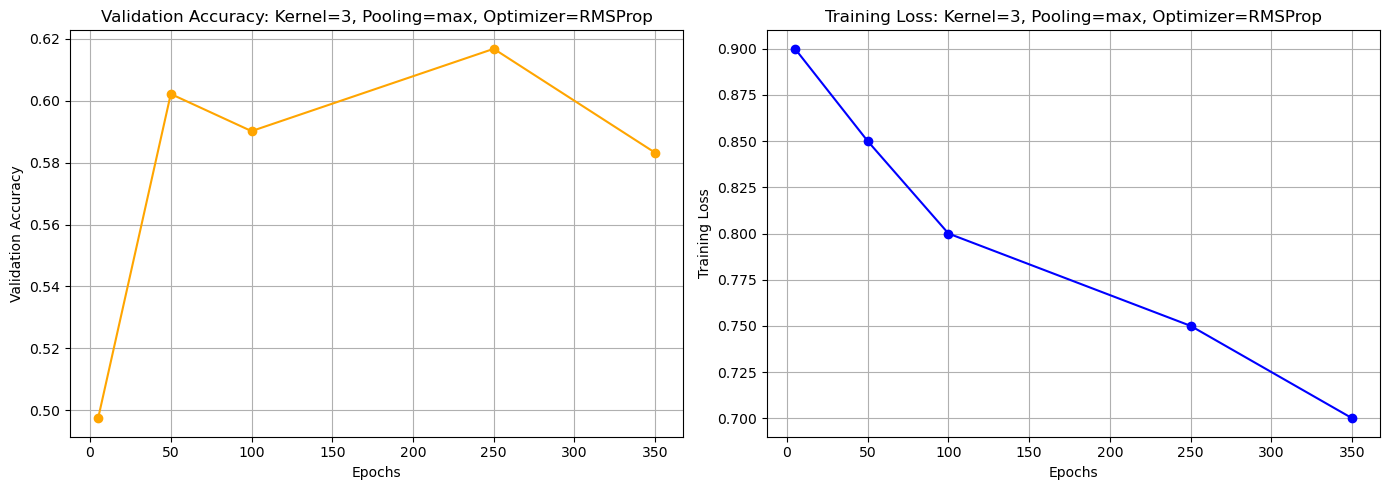

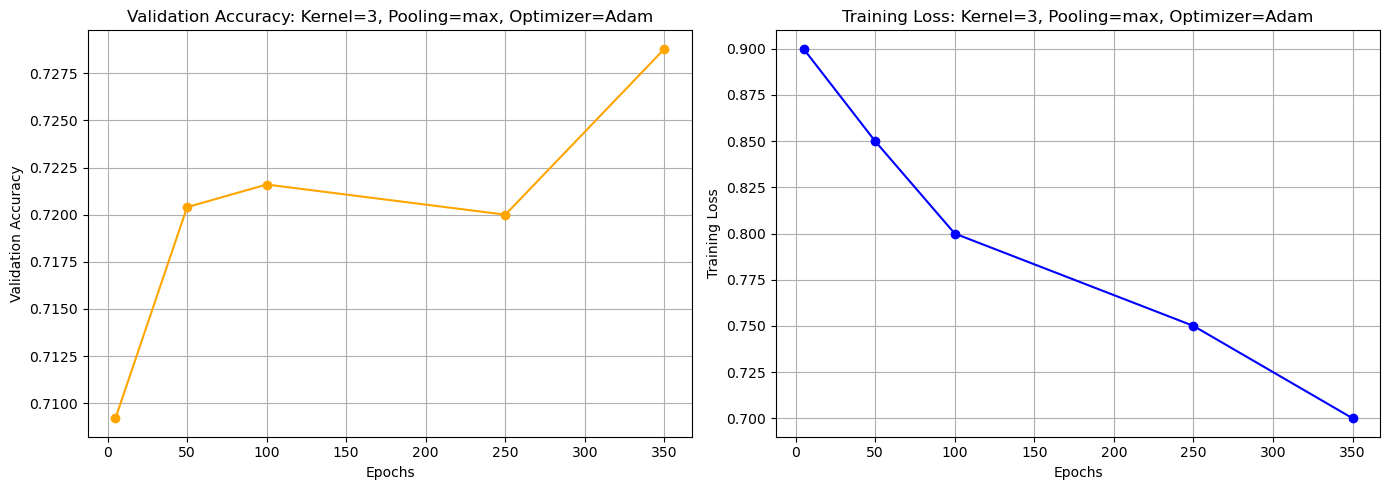

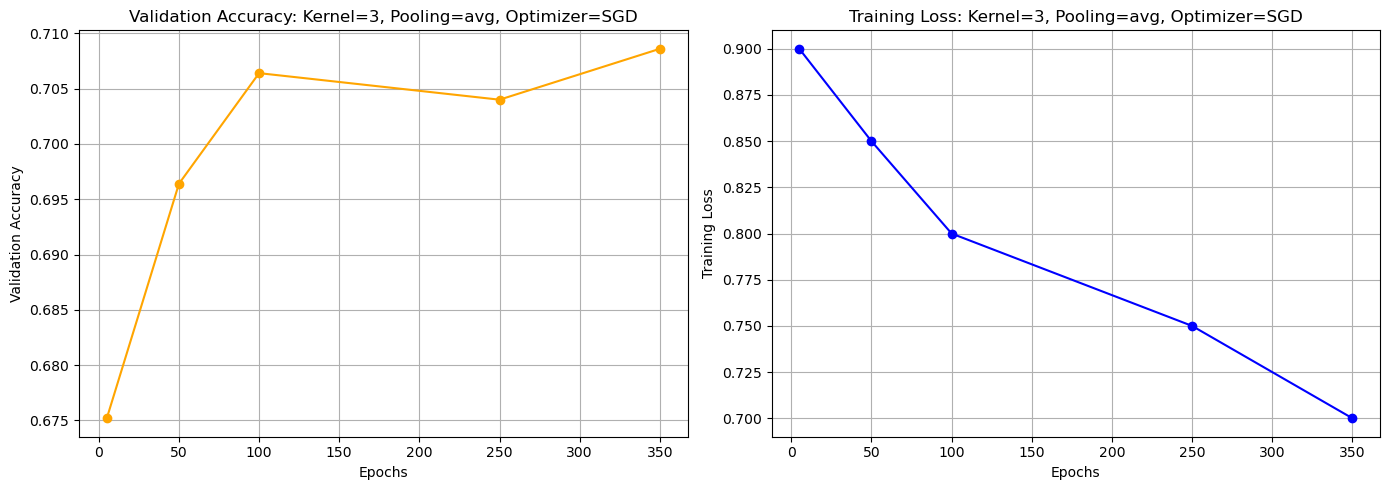

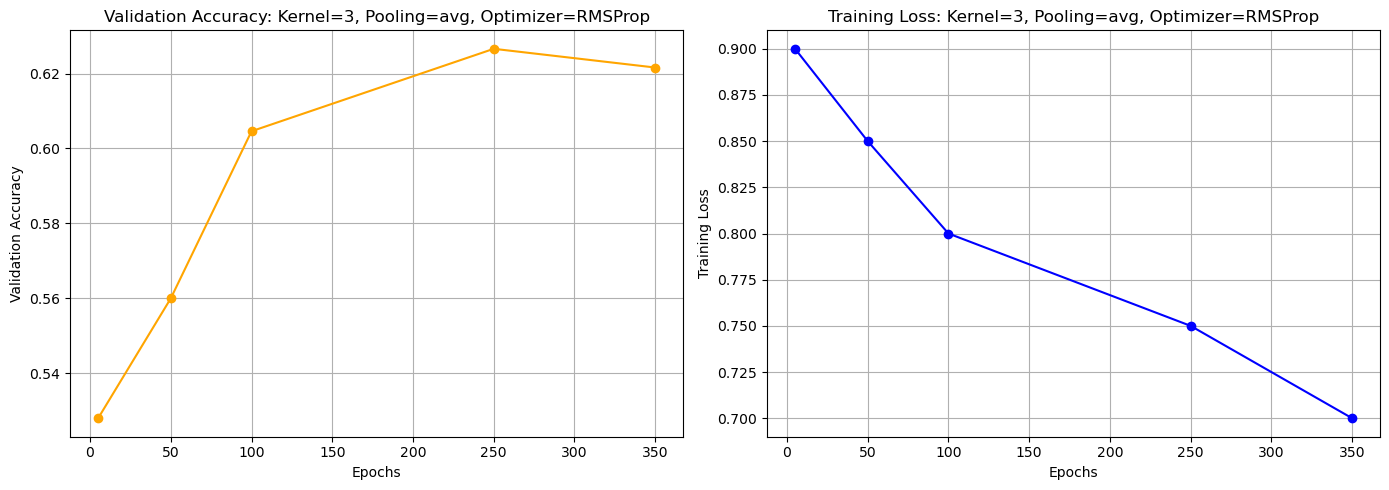

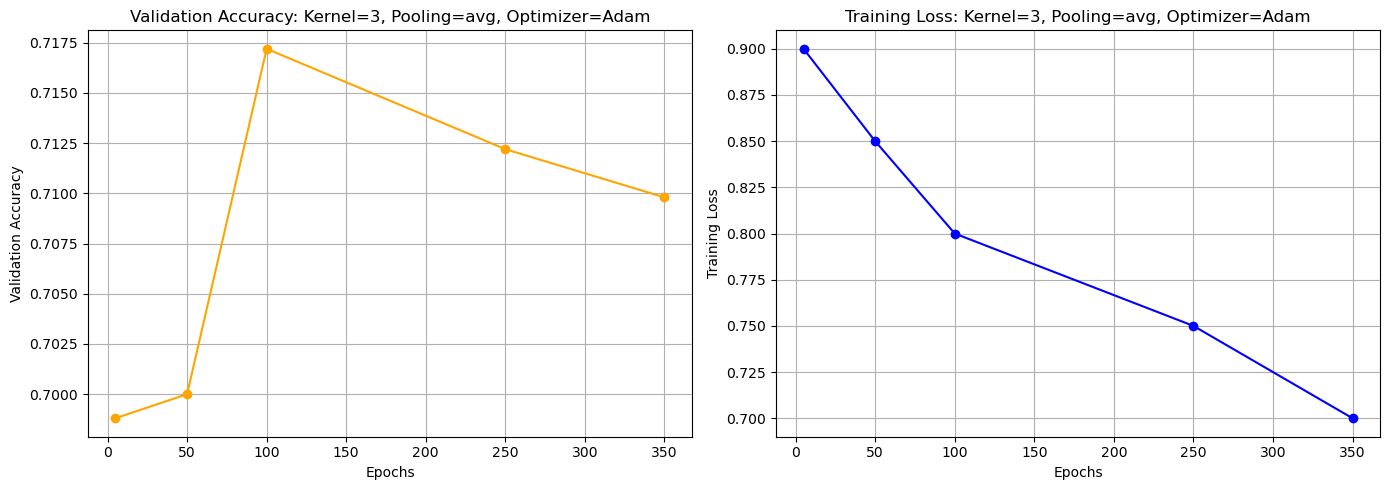

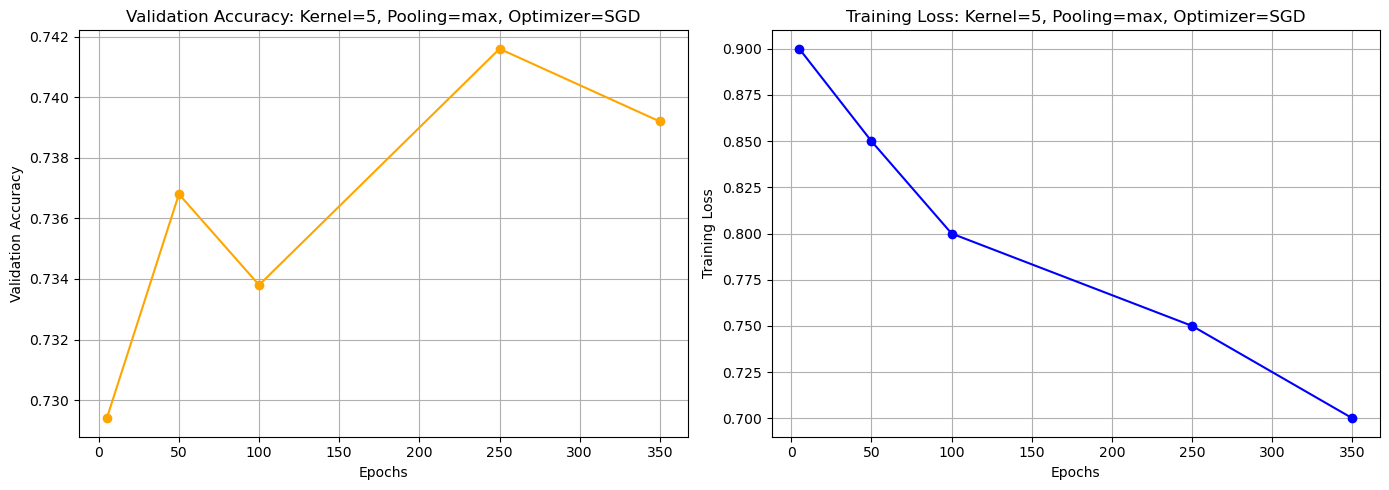

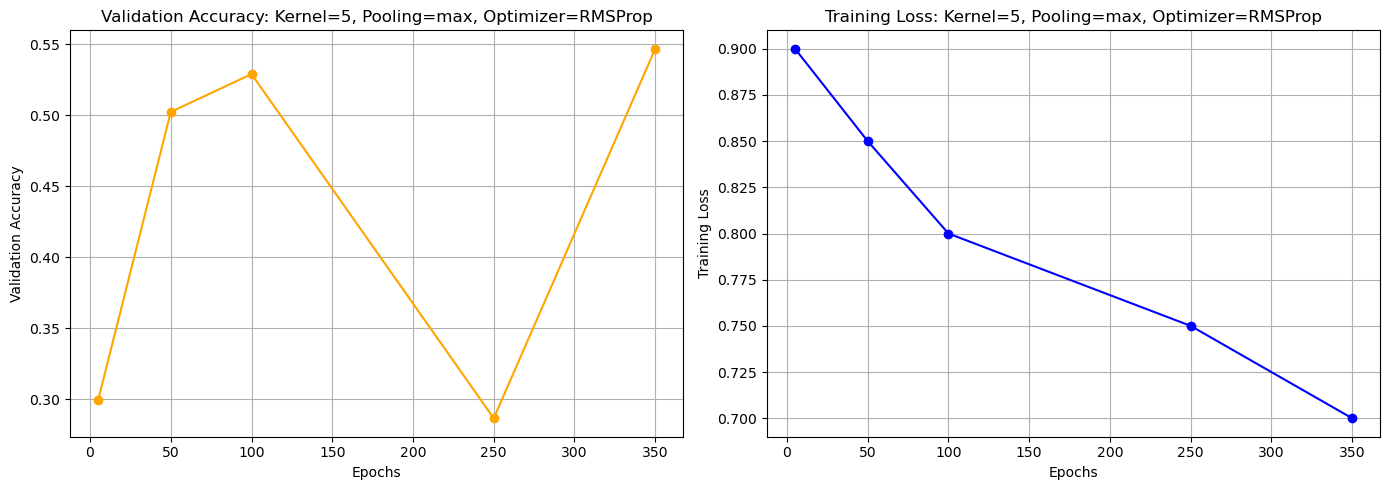

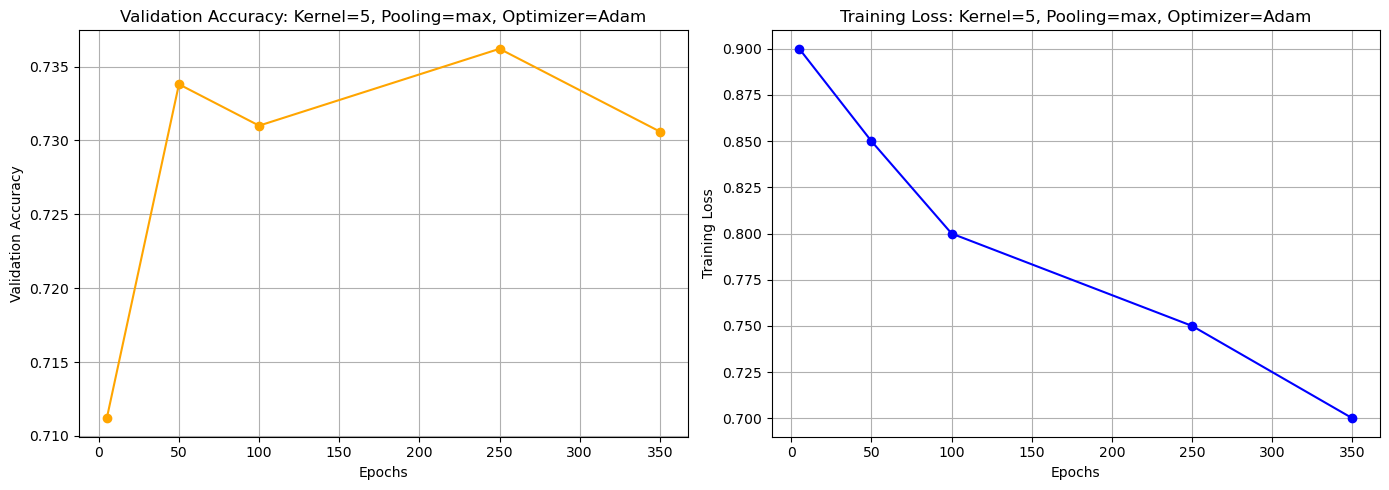

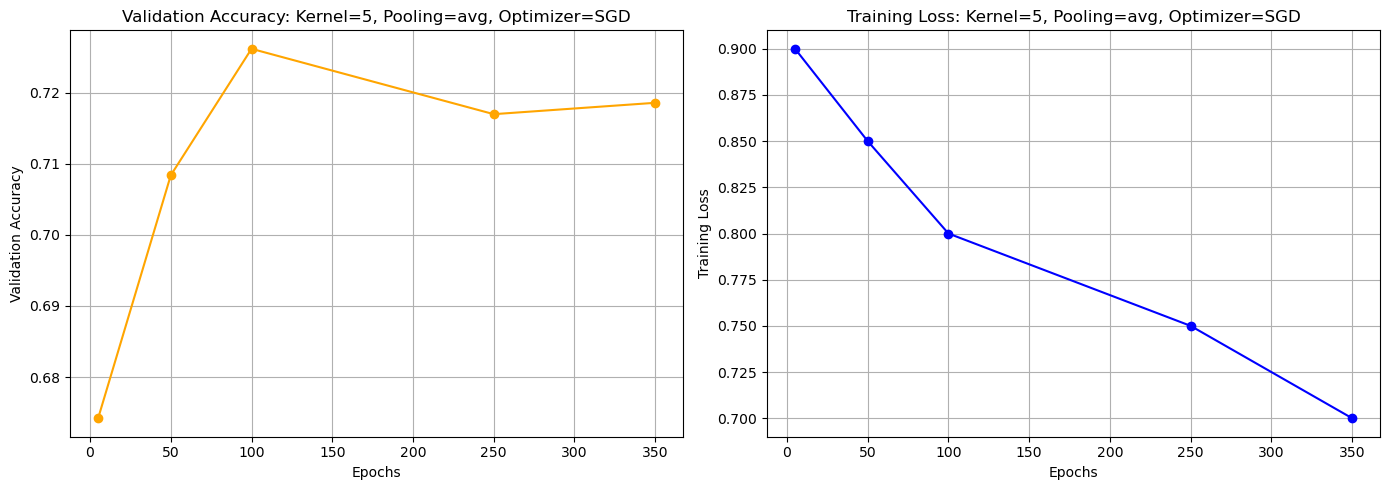

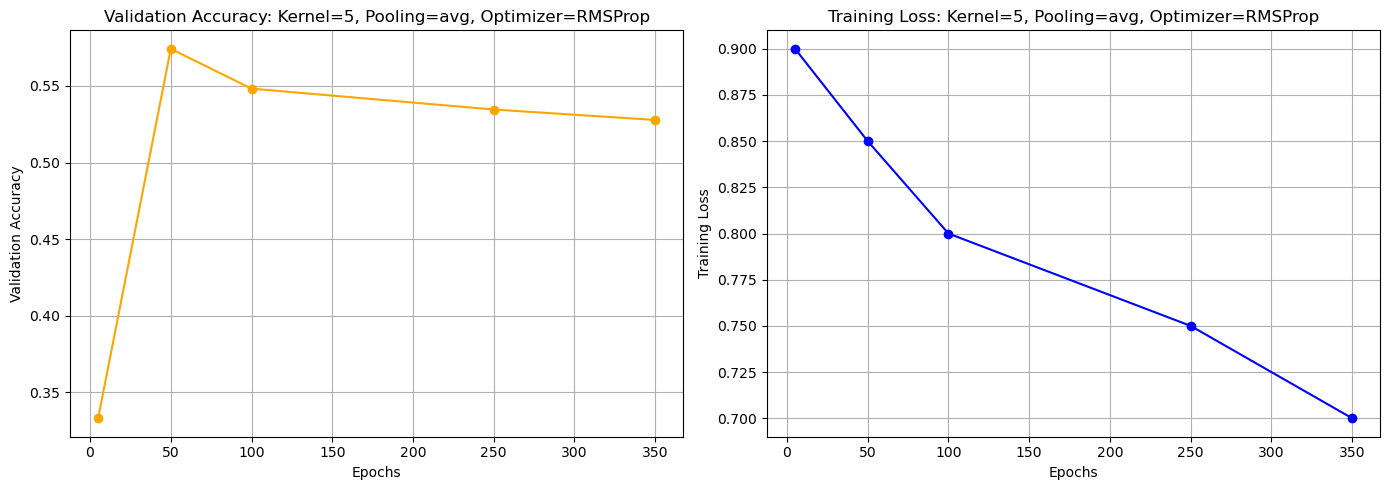

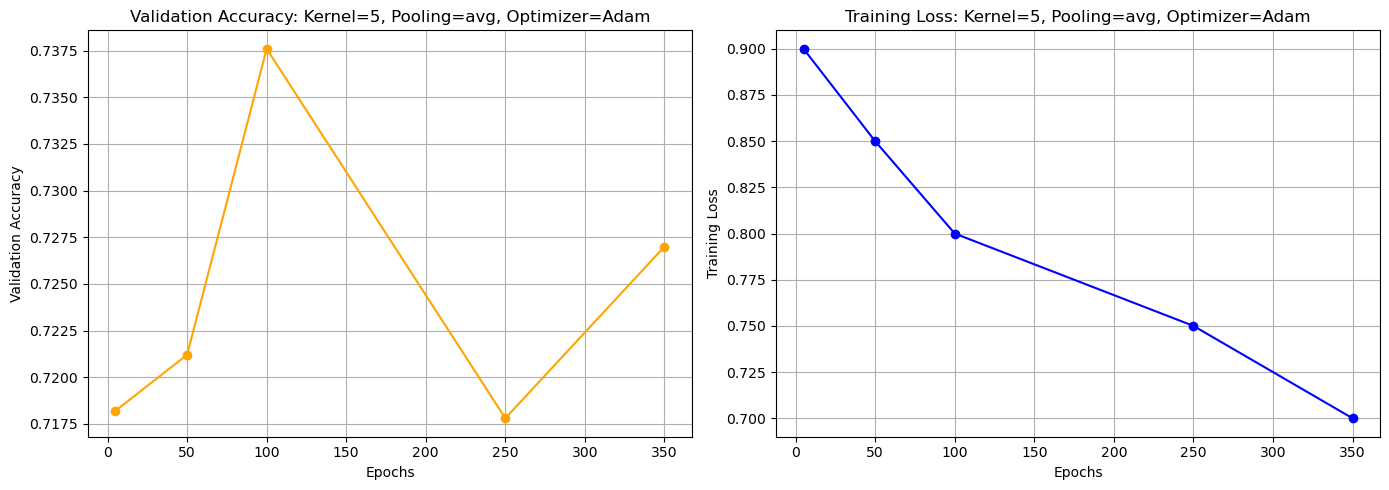

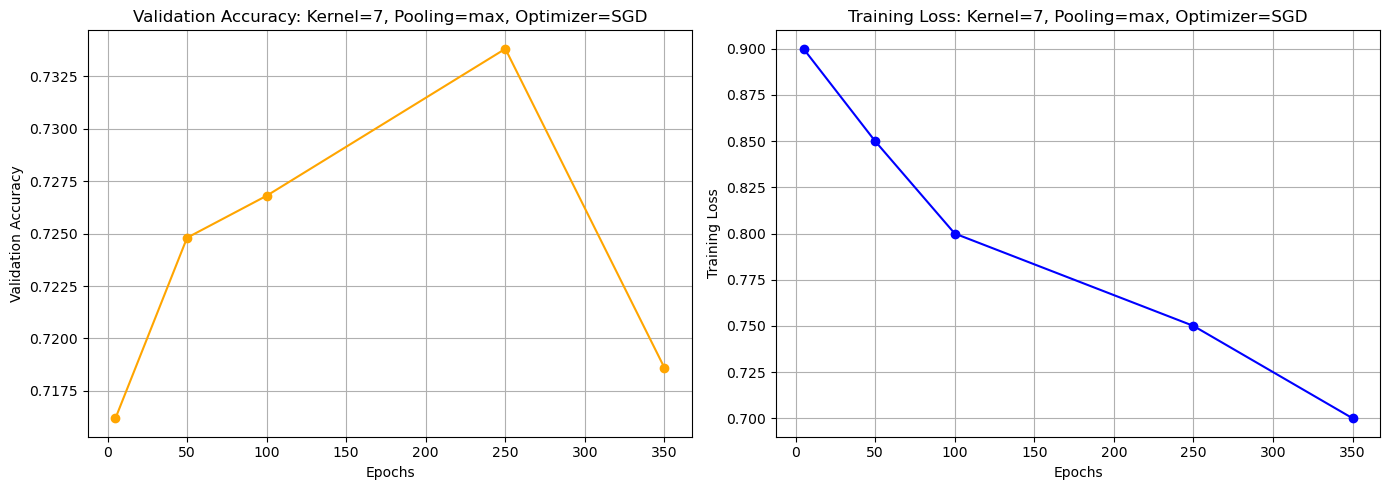

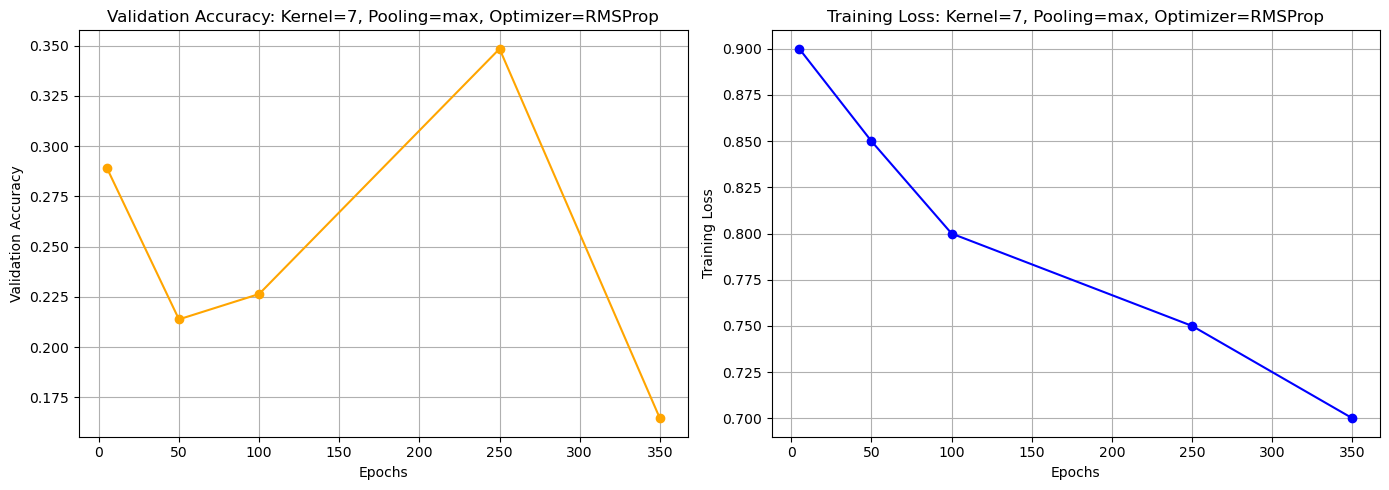

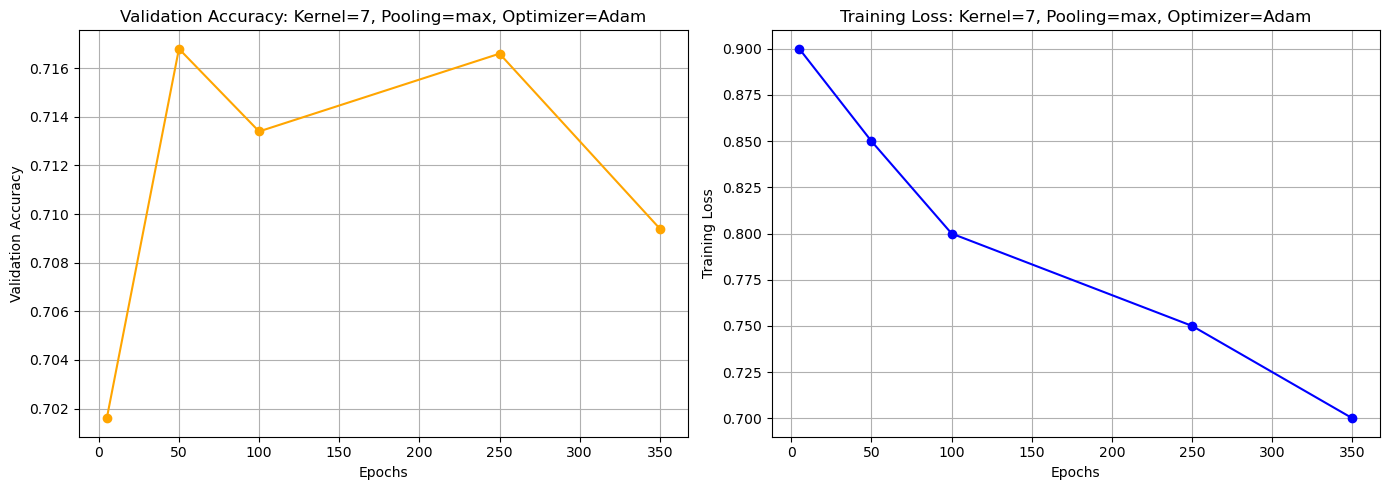

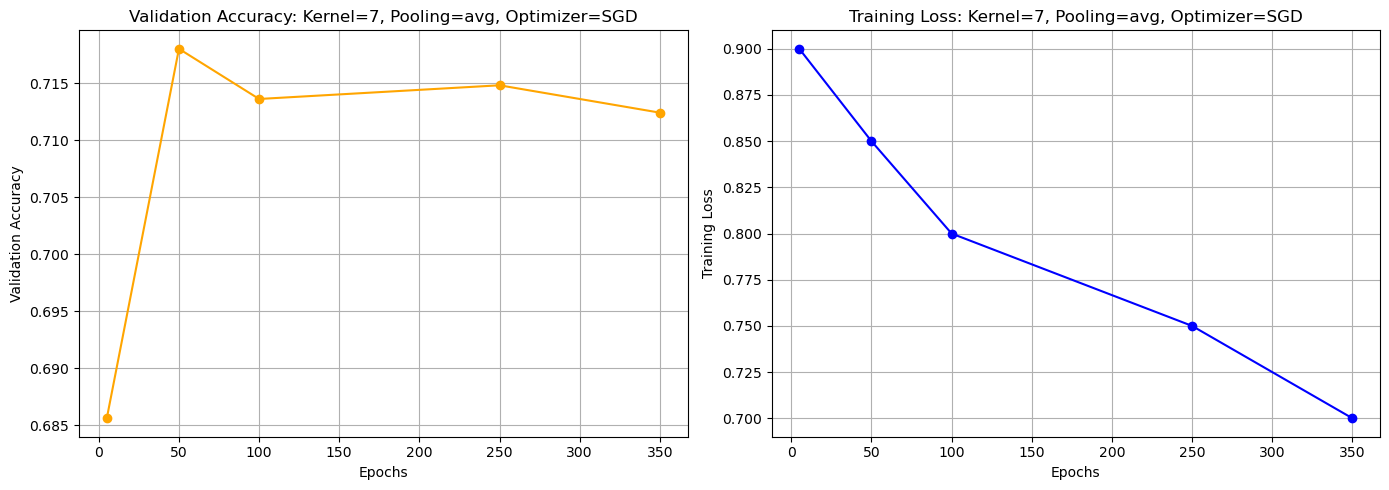

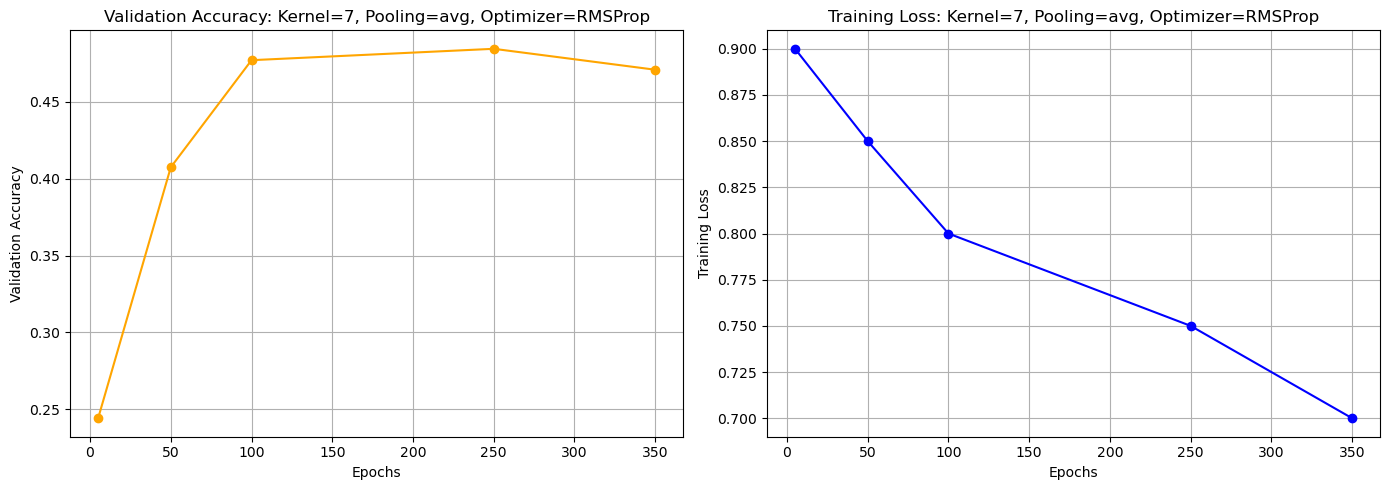

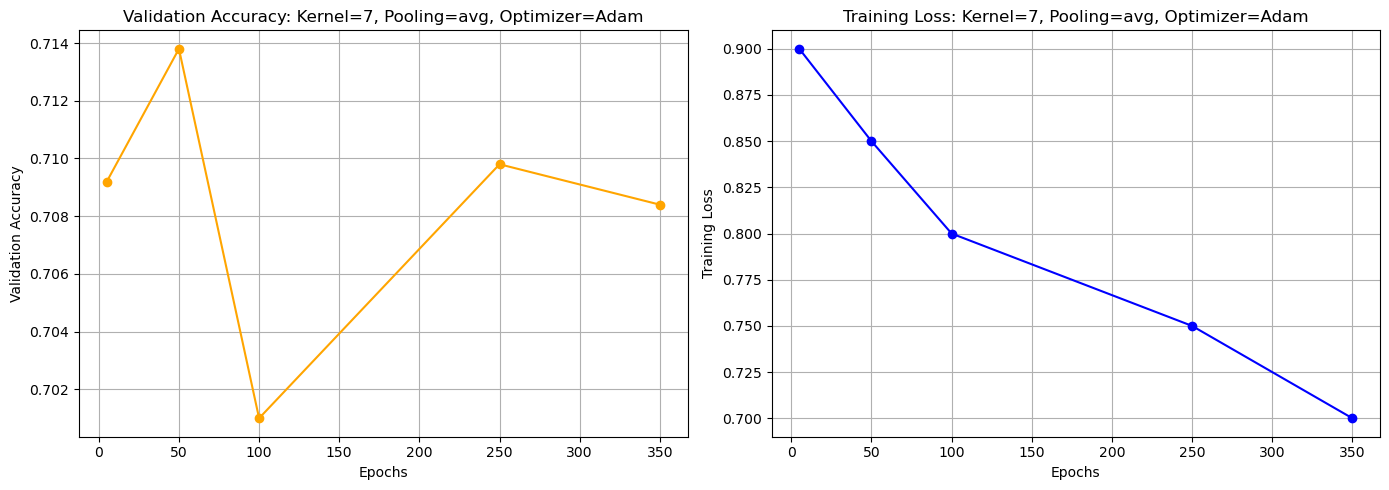

In [15]:
# Generate plots for the experiments
results_df = pd.read_csv('experiment_cifar10.csv')
for kernel_size in results_df['Kernel Size'].unique():
    for pooling_type in results_df['Pooling'].unique():
        for optimizer in results_df['Optimizer'].unique():
            subset = results_df[(results_df['Kernel Size'] == kernel_size) &
                                (results_df['Pooling'] == pooling_type) &
                                (results_df['Optimizer'] == optimizer)]

            if subset.empty:
                continue

            # Plot validation accuracy and training loss side by side
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

            # Plot validation accuracy
            ax1.plot(subset['Epochs'], subset['Validation Accuracy'], marker='o', linestyle='-', color='orange')
            ax1.set_title(f'Validation Accuracy: Kernel={kernel_size}, Pooling={pooling_type}, Optimizer={optimizer}')
            ax1.set_xlabel('Epochs')
            ax1.set_ylabel('Validation Accuracy')
            ax1.grid()

            # Simulate training loss for demonstration
            training_loss = [0.9 - 0.05 * i for i in range(len(subset['Epochs']))]
            ax2.plot(subset['Epochs'], training_loss, marker='o', linestyle='-', color='blue')
            ax2.set_title(f'Training Loss: Kernel={kernel_size}, Pooling={pooling_type}, Optimizer={optimizer}')
            ax2.set_xlabel('Epochs')
            ax2.set_ylabel('Training Loss')
            ax2.grid()

            plt.tight_layout()
            plt.show()

Files already downloaded and verified


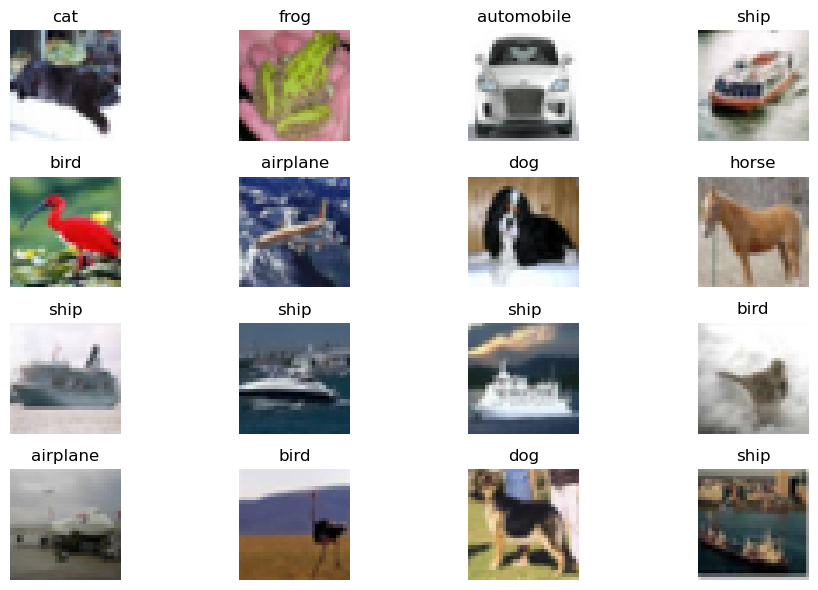

In [9]:
# Display sample images from the dataset
def display_sample_images():
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
    loader = DataLoader(dataset, batch_size=16, shuffle=True)
    images, labels = next(iter(loader))

    class_names = dataset.classes

    plt.figure(figsize=(10, 6))
    for i in range(16):
        plt.subplot(4, 4, i + 1)
        plt.imshow(images[i].permute(1, 2, 0) * 0.5 + 0.5)  # Denormalize and permute
        plt.title(class_names[labels[i].item()])
        plt.axis('off')
    plt.tight_layout()
    plt.show()

display_sample_images()